In [1]:
import os
import logging
import random
import typing as T
import json
import multiprocessing
import ctypes
from multiprocessing import Pool, cpu_count, Array
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from matchms.importing import load_from_mgf
from tqdm import tqdm
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.rdMolDescriptors import CalcMolFormula, CalcExactMolWt

# import massspecgym.utils as utils

In [2]:
random.seed(0)

tqdm.pandas()

# Suppress RDKit warnings and errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [8]:
def compute_formula(smiles):
    if pd.isna(smiles):
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return CalcMolFormula(mol)
    else:
        return None

def compute_weight(smiles):

    if pd.isna(smiles):
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return CalcExactMolWt(mol)
    else:
        return None

# computing condidates

In [3]:
df_1M = pd.read_csv('/storage/plzen1/home/jozefov_147/MSn/candidates/MassSpecGym_retrieval_molecules_1M.tsv', sep='\t')
df_1M.shape, df_1M.columns

((1032456, 5),
 Index(['smiles', 'inchi_key_2D', 'inchi', 'formula', 'weight'], dtype='object'))

In [4]:
df_4M = pd.read_csv('/storage/plzen1/home/jozefov_147/MSn/candidates/MassSpecGym_retrieval_molecules_4M.tsv', sep='\t')
df_4M.shape, df_4M.columns

((4175091, 4),
 Index(['smiles', 'inchikey', 'formula', 'weight'], dtype='object'))

In [5]:
df_pubchem = pd.read_csv('/storage/plzen1/home/jozefov_147/MSn/candidates/MassSpecGym_retrieval_molecules_pubchem_118M.tsv', sep='\t')
df_pubchem.shape, df_pubchem.columns

((118008573, 4),
 Index(['smiles', 'formula', 'mass', 'inchi_key_2D'], dtype='object'))

In [6]:
df_1M = df_1M.rename(columns={'weight': 'mass'})
df_4M = df_4M.rename(columns={'weight': 'mass'})

In [16]:
df_4M = df_4M.rename(columns={'inchikey': 'inchi_key_2D'})

In [7]:
spectra = list(load_from_mgf('/storage/plzen1/home/jozefov_147/MSn/candidates/20241211_msn_library_pos_all_lib_MSn.mgf'))

In [13]:
smiles = pd.Series([s.metadata['smiles'] for s in spectra])
smiles = smiles.drop_duplicates()
len(spectra), len(smiles)

(803405, 14008)

In [22]:
df_4M = df_4M.rename(columns={'inchi_key_2D\t': 'inchi_key_2D'})

In [23]:
df_4M.head()

,smiles,inchi_key_2D,formula,mass
0,CCCCCCC=CCCCC=CCCCCC=O,AMVROEXDYFQCMJ,C18H32O,264.245316
1,CCCCCCC=CC=CCCCCCCCC(=O)OC(COC(=O)CCCCCCCCCCCC...,BGVVPZDHBNNISC,C72H136O17P2,1334.925276
2,CCOC(=O)C1=CC=C(C=C1)NC(=S)NNC(=O)COC,SPIWIONSMQIGRJ,C13H17N3O4S,311.093977
3,CC1=CC=C(C=C1)NC2=NN=C(S2)C3=CC=CC=C3Cl,ZMDVBLUMPUTJMY,C15H12ClN3S,301.044046
4,C1=CC=C(C(=C1)C2=NC3=C(C=C2)C(=C(S3)C(=O)N)N)F,JJWMIZJMFIBGIJ,C14H10FN3OS,287.052861


## Generate retrieval candidates from molecule sets for the spectral library


In [9]:
def dedup(seq):
    """Deduplicate list while preserving order (https://stackoverflow.com/a/480227)"""
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def init(shared_smiles, shared_formula, shared_mass, shared_inchi_key_2D):
    global df_smiles, df_formula, df_mass, df_inchi_key_2d
    df_smiles = shared_smiles
    df_formula = shared_formula
    df_mass = shared_mass
    df_inchi_key_2d = shared_inchi_key_2D

def get_candidates_single(args):
    index, smiles, cand_type, max_cands = args
    candidates_single = []

    # Log the process ID
    # logging.info(f'Process ID: {os.getpid()} handling SMILES: {smiles}')

    # Add query SMILES as one of the candidates
    if not candidates_single:
        candidates_single.append(smiles)

    # Query is already saturated with candidates
    if len(candidates_single) == max_cands:
        return candidates_single

    # Find new candidates for the query
    mol = Chem.MolFromSmiles(smiles)
    inchi_key_2D = Chem.MolToInchiKey(mol).split("-")[0]
    if cand_type == 'formula':
        formula = CalcMolFormula(mol)
        new_cands = [
            df_smiles[i] for i in range(len(df_smiles))
            if df_formula[i] == formula and df_inchi_key_2d[i] != inchi_key_2D
        ]
    elif cand_type == 'mass':
        mass = CalcExactMolWt(mol)
        mass_eps = mass * 1e-6 * 10  # 10 ppm
        new_cands = [
            df_smiles[i] for i in range(len(df_smiles))
            if abs(df_mass[i] - mass) < mass_eps and df_inchi_key_2d[i] != inchi_key_2D
        ]
    else:
        raise ValueError(f'Unknown candidates type {cand_type}.')

    # Shuffle new candidates to reach a random sample if pruned in the next step
    random.shuffle(new_cands)

    # Add new candidates until the maximum number is reached
    candidates_single.extend(new_cands)
    candidates_single = dedup(candidates_single)[:max_cands]

    return candidates_single

def get_candidates_parallel(
        query_smiles: T.Iterable[str],
        df: pd.DataFrame,
        cand_type: str = 'formula',
        max_cands: int = 256,
        df_candidates: T.Optional[pd.DataFrame] = None,
        max_workers: int = cpu_count() - 2
    ) -> pd.DataFrame:
    """For query SMILES strings, find similar SMILES from the dataframe in parallel"""
    logging.info('Starting get_candidates_parallel')

    if df_candidates is None:
        df_candidates = pd.DataFrame({'smiles': query_smiles, 'cands': [[] for _ in query_smiles]})
        logging.info('Initialized df_candidates with empty candidate lists')

    # Convert DataFrame columns to numpy arrays
    df_smiles_array = df['smiles'].to_numpy()
    df_formula_array = df['formula'].fillna('').to_numpy()
    df_mass_array = df['mass'].to_numpy()
    df_inchi_key_2d_array = df['inchi_key_2D'].fillna('').to_numpy()

    # Create shared arrays not to copy df for each process (critical in the case of whole PubChem)
    shared_smiles = Array(ctypes.c_wchar_p, df_smiles_array, lock=False)
    shared_formula = Array(ctypes.c_wchar_p, df_formula_array, lock=False)
    shared_mass = Array(ctypes.c_double, df_mass_array, lock=False)
    shared_inchi_key_2D = Array(ctypes.c_wchar_p, df_inchi_key_2d_array, lock=False)

    logging.info(f'Setting up shared arrays with {max_workers} workers')
    
    with Pool(
        processes=max_workers,
        initializer=init,
        initargs=(shared_smiles, shared_formula, shared_mass, shared_inchi_key_2D)
    ) as pool:
        args = [(index, row['smiles'], cand_type, max_cands) for index, row in df_candidates.iterrows()]
        
        # Use tqdm to show the progress bar
        results = []
        for result in tqdm(pool.imap(get_candidates_single, args), total=len(args)):
            results.append(result)
        
        df_candidates['cands'] = results
        logging.info('Finished multiprocessing pool')

    logging.info('Completed get_candidates_parallel')
    return df_candidates

2025-01-18 16:35:31,896 - INFO - Starting get_candidates_parallel
2025-01-18 16:35:31,908 - INFO - Initialized df_candidates with empty candidate lists
2025-01-18 16:35:34,181 - INFO - Setting up shared arrays with 126 workers
100%|████████████████████████████████████| 14008/14008 [00:35<00:00, 399.65it/s]
2025-01-18 16:37:48,476 - INFO - Finished multiprocessing pool
2025-01-18 16:37:51,339 - INFO - Completed get_candidates_parallel


<Axes: >

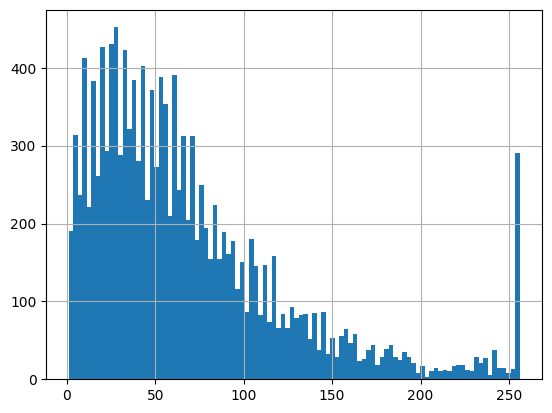

In [10]:
candidates = get_candidates_parallel(smiles, df_1M, cand_type='mass')
candidates['cands'].apply(len).hist(bins=100)

In [11]:
candidates.to_pickle('cands_1M_mass.pkl')

2025-01-18 16:41:49,794 - INFO - Starting get_candidates_parallel
2025-01-18 16:42:00,011 - INFO - Setting up shared arrays with 126 workers
100%|████████████████████████████████████| 14008/14008 [01:56<00:00, 120.14it/s]
2025-01-18 16:45:45,893 - INFO - Finished multiprocessing pool
2025-01-18 16:45:49,108 - INFO - Completed get_candidates_parallel


<Axes: >

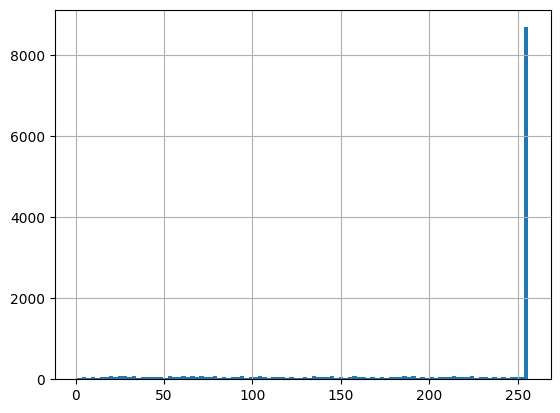

In [24]:
candidates = get_candidates_parallel(smiles, df_4M, cand_type='mass', df_candidates=candidates)
candidates['cands'].apply(len).hist(bins=100)

In [25]:
candidates.to_pickle('cands_4M_mass.pkl')

2025-01-18 16:45:53,382 - INFO - Starting get_candidates_parallel
2025-01-18 16:52:14,269 - INFO - Setting up shared arrays with 126 workers
100%|█████████████████████████████████████| 14008/14008 [54:54<00:00,  4.25it/s]
2025-01-18 17:53:08,190 - INFO - Finished multiprocessing pool
2025-01-18 17:53:18,757 - INFO - Completed get_candidates_parallel


<Axes: >

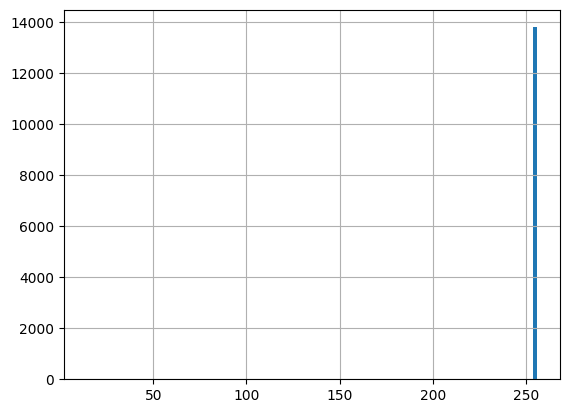

In [26]:
candidates = get_candidates_parallel(smiles, df_pubchem, cand_type='mass', df_candidates=candidates)
candidates['cands'].apply(len).hist(bins=100)

In [27]:
candidates.to_pickle('cands_pubchem_118M_mass.pkl')

In [28]:
# Write candidates dictionary to JSON file
with open('MassSpecGymMSn_retrieval_candidates_mass.json', 'w') as json_file:
    candidates_dict = dict(zip(candidates['smiles'], candidates['cands']))
    json.dump(candidates_dict, json_file)

# Genereta Formula

In [29]:
len(smiles)

14008

2025-01-18 17:54:50,131 - INFO - Starting get_candidates_parallel
2025-01-18 17:54:50,143 - INFO - Initialized df_candidates with empty candidate lists
2025-01-18 17:54:52,457 - INFO - Setting up shared arrays with 126 workers
100%|████████████████████████████████████| 14008/14008 [00:44<00:00, 314.49it/s]
2025-01-18 17:57:28,211 - INFO - Finished multiprocessing pool
2025-01-18 17:57:31,467 - INFO - Completed get_candidates_parallel


<Axes: >

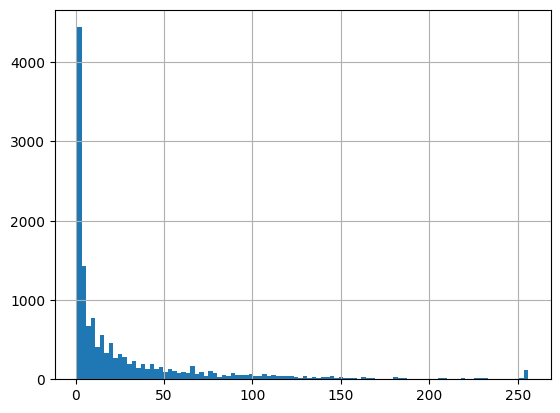

In [30]:
candidates = get_candidates_parallel(smiles, df_1M, cand_type='formula')
candidates['cands'].apply(len).hist(bins=100)

In [31]:
candidates.to_pickle('cands_1M_formula.pkl')

2025-01-18 17:57:32,553 - INFO - Starting get_candidates_parallel
2025-01-18 17:57:43,547 - INFO - Setting up shared arrays with 126 workers
100%|█████████████████████████████████████| 14008/14008 [02:22<00:00, 98.02it/s]
2025-01-18 18:02:10,526 - INFO - Finished multiprocessing pool
2025-01-18 18:02:14,038 - INFO - Completed get_candidates_parallel


<Axes: >

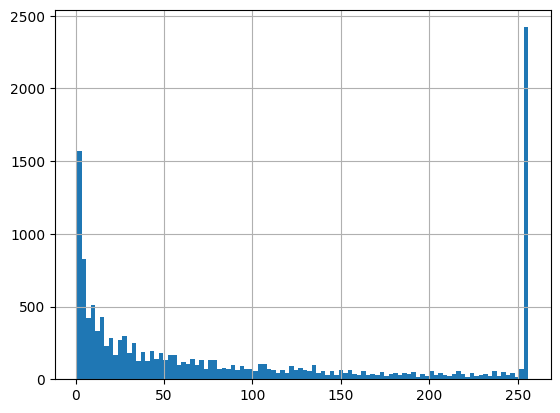

In [32]:
candidates = get_candidates_parallel(smiles, df_4M, cand_type='formula', df_candidates=candidates)
candidates['cands'].apply(len).hist(bins=100)

In [33]:
candidates.to_pickle('cands_4M_formula.pkl')

2025-01-18 18:29:15,717 - INFO - Starting get_candidates_parallel
2025-01-18 18:35:42,154 - INFO - Setting up shared arrays with 126 workers
100%|█████████████████████████████████████| 14008/14008 [53:43<00:00,  4.35it/s]
2025-01-18 19:41:07,518 - INFO - Finished multiprocessing pool
2025-01-18 19:41:24,750 - INFO - Completed get_candidates_parallel


<Axes: >

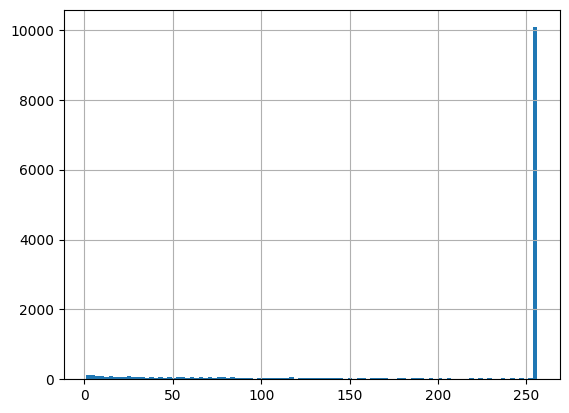

In [35]:
candidates = get_candidates_parallel(smiles, df_pubchem, cand_type='formula', df_candidates=candidates)
candidates['cands'].apply(len).hist(bins=100)

In [36]:
candidates.to_pickle('cands_pubchem_118M_formula.pkl')

In [37]:
# Write candidates dictionary to JSON file
with open('MassSpecGymMSn_retrieval_candidates_formula.json', 'w') as json_file:
    candidates_dict = dict(zip(candidates['smiles'], candidates['cands']))
    json.dump(candidates_dict, json_file)

In [9]:
! python -V

Python 3.6.10


In [12]:
! conda activate /storage/plzen1/home/jozefov_147/.conda/envs/candidates_env


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [11]:
! module add conda-modules-py37